#用正态随机过程处理回归

这个主题将介绍如何用正态随机过程（Gaussian process，GP）处理回归问题。在线性模型部分，我们曾经见过在变量间可能存在相关性时，如何用贝叶斯岭回归(Bayesian Ridge Regression)表示先验概率分布（prior）信息。

正态分布过程关心的是方程而不是均值。但是，如果我们假设一个正态分布的均值为0，那么我们需要确定协方差。

这样处理就与线性回归问题中先验概率分布可以用相关系数表示的情况类似。用GP处理的先验就可以用数据、样本数据间协方差构成函数表示，因此必须从数据中拟合得出。具体内容参考[The Gaussian Processes Web Site](http://www.gaussianprocess.org/)。

<!-- TEASER_END -->

##Getting ready

首先要我们用一些数据来演示用scikit-learn处理GP：

In [1]:
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()
boston_X = boston.data
boston_y = boston.target
train_set = np.random.choice([True, False], len(boston_y), p=[.75, .25])

##How to do it...

有了数据之后，我们就创建scikit-learn的`GaussianProcess`对象。默认情况下，它使用一个常系数回归方程（constant regression function）和平方指数相关函数（ squared exponential correlation），是最主流的选择之一：

In [2]:
from sklearn.gaussian_process import GaussianProcess
gp = GaussianProcess()
gp.fit(boston_X[train_set], boston_y[train_set])

GaussianProcess(beta0=None,
        corr=<function squared_exponential at 0x0000000006F1C950>,
        normalize=True, nugget=array(2.220446049250313e-15),
        optimizer='fmin_cobyla', random_start=1,
        random_state=<mtrand.RandomState object at 0x00000000052A4BA8>,
        regr=<function constant at 0x0000000006F15950>,
        storage_mode='full', theta0=array([[ 0.1]]), thetaL=None,
        thetaU=None, verbose=False)

其中，

- `beta0`：回归权重。默认是用MLE（最大似然估计，Maximum Likelihood Estimation）方法进行估计。
- `corr`：相关系数方程。提供了若干种方程，后面会介绍。
- `normalize`：默认是`True`，中性化调整样本值，方便应用MLE进行估计。
- `nugget`：正则化参数，是可选的，默认是一个很小的值。你可以将这个参数用于每个样本值（参数是一个数值），也可以对样本值使用不同的参数（参数是一个数组，与样本值个数相等）。
- `regr`：默认是常系数回归方程。

现在让我们拟合对象看看测试效果：

In [3]:
test_preds = gp.predict(boston_X[~train_set])

让我们把预测值和实际值画出来比较一下。因为我们做了回归，还可以看看残差散点图和残差直方图。

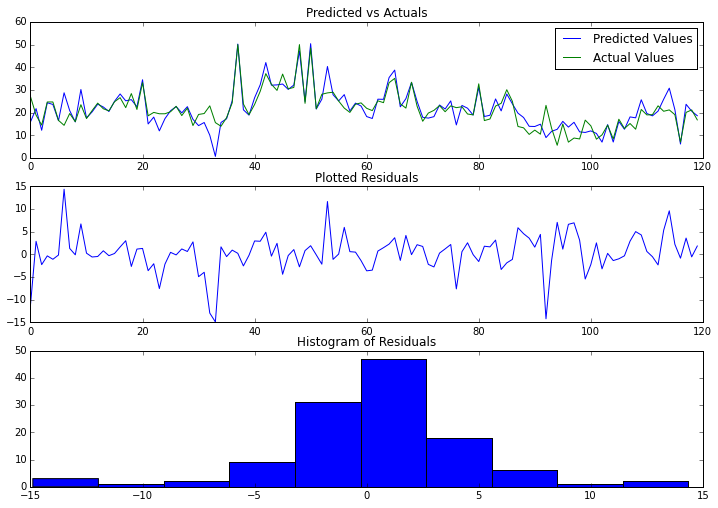

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(10, 7), nrows=3)
f.tight_layout()
ax[0].plot(range(len(test_preds)), test_preds, label='Predicted Values');
ax[0].plot(range(len(test_preds)), boston_y[~train_set], label='Actual Values');
ax[0].set_title("Predicted vs Actuals")
ax[0].legend(loc='best')
ax[1].plot(range(len(test_preds)),
test_preds - boston_y[~train_set]);
ax[1].set_title("Plotted Residuals")
ax[2].hist(test_preds - boston_y[~train_set]);
ax[2].set_title("Histogram of Residuals");

##How it works...

上面我们快速演示了一下，现在让我们看看这些参数，看看如何优化它们。首先，我们看看`corr`函数的类型。这个函数描述了不同组`X`之间的相关性。scikit-learn提供了5种函数类型：

- 绝对值指数函数（absolute_exponential）
- 平方指数函数（squared_exponential）
- 广义指数函数（generalized_exponential）
- 立方项函数（cubic）
- 线性函数（linear）

例如，平方指数函数公式如下：

$$K= \exp {-\frac {|d|^2}{2l^2}}$$

另外，线性函数就是两个点的点积：

$$K=x^T{x'}$$

另一个参数是`theta0`，表示参数估计的起始点。

一旦我们有了$K$和均值的估计值，过程就完全确定了，因为它是一个GP；之所以用正态分布，是因为在机器学习中它一直很受欢迎。

下面我们换个`regr`函数类型和`theta0`参数，看看结果会如何变化：

In [5]:
gp = GaussianProcess(regr='linear', theta0=5e-1)
gp.fit(boston_X[train_set], boston_y[train_set]);
linear_preds = gp.predict(boston_X[~train_set])

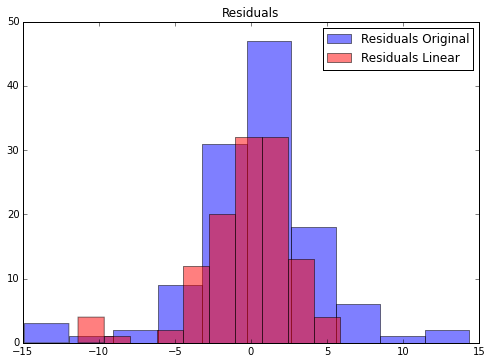

In [6]:
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(test_preds - boston_y[~train_set],label='Residuals Original', color='b', alpha=.5);
ax.hist(linear_preds - boston_y[~train_set],label='Residuals Linear', color='r', alpha=.5);
ax.set_title("Residuals")
ax.legend(loc='best');

很明显，第二个模型的预测效果大部分区间要更好。如果我们把残差汇总起来，我们可以看看MSE预测的结果：

In [7]:
np.power(test_preds - boston_y[~train_set], 2).mean()

17.456331927446904

In [8]:
np.power(linear_preds - boston_y[~train_set], 2).mean()

9.320038747573518

##There's more...

我们可能还想掌握估计的不确定性。在我们预测的时候，如果我们`eval_MSE`设置为`True`，我们就获得MSE的值，这时预测返回的是预测值与MSE估计值的元组。

In [11]:
test_preds, MSE = gp.predict(boston_X[~train_set], eval_MSE=True)
MSE[:5]

array([ 5.14026315,  5.30852052,  0.91152632,  2.87148688,  2.55714482])

这样我们就可以计算估计的误差了。让我们画出来看看准确率：

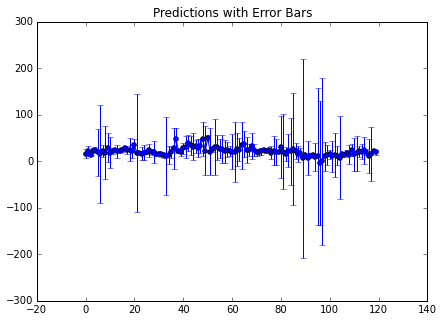

In [32]:
f, ax = plt.subplots(figsize=(7, 5))
n = 120
rng = range(n)
ax.scatter(rng, test_preds[:n])
ax.errorbar(rng, test_preds[:n], yerr=1.96*MSE[:n])
ax.set_title("Predictions with Error Bars")
ax.set_xlim((-20, 140));

你会看到，许多点的估计都有些变化。但是，前面的数据显示，总体误差不是特别大。